In [2]:
pip install tensorflow_model_optimization

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import tensorflow_model_optimization as tfmot
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow_model_optimization.sparsity.keras import PolynomialDecay, prune_low_magnitude
from tensorflow.keras.models import Model
import numpy as np
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications.densenet import preprocess_input
#from tensorflow_model_optimization.sparsity.keras import UpdatePruningStep
import os
from tensorflow_model_optimization.python.core.sparsity.keras.pruning_callbacks import UpdatePruningStep
# importing all the required modules
from sklearn.metrics import classification_report, confusion_matrix

C:\Users\Lenovo\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50
#These constants define key parameters for model training: BATCH_SIZE (32 samples per iteration), IMAGE_SIZE (256x256 pixels), CHANNELS (3 for RGB images), and EPOCHS (50 training epochs).

In [3]:
# Get the absolute path to the desktop
desktop_path = str(Path.home() / "Desktop")

# Specify the path to the dataset folder
dataset_path = os.path.join(desktop_path, "potato_leaf_dataset")

# Create the image dataset from the specified directory
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)
#The code obtains the absolute path to the desktop (desktop_path) and constructs the dataset path by appending "potato_leaf_dataset" to the desktop path (dataset_path). 
#Then, it creates an image dataset using TensorFlow's image_dataset_from_directory function

<IPython.core.display.Javascript object>

Found 4072 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names
class_names
#retrieves the class names from the previously created dataset and assigns them to the variable class_names.

['EarlyBlight', 'Healthy', 'LateBlight']

In [12]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    #iterating over the 1st batch of the dataset and printing shape of the image batch and the corresponding labels in numpy format.

(32, 256, 256, 3)
[1 2 1 0 1 0 0 1 1 0 1 2 0 1 0 1 1 2 1 0 1 1 2 0 2 1 1 0 0 2 2 2]


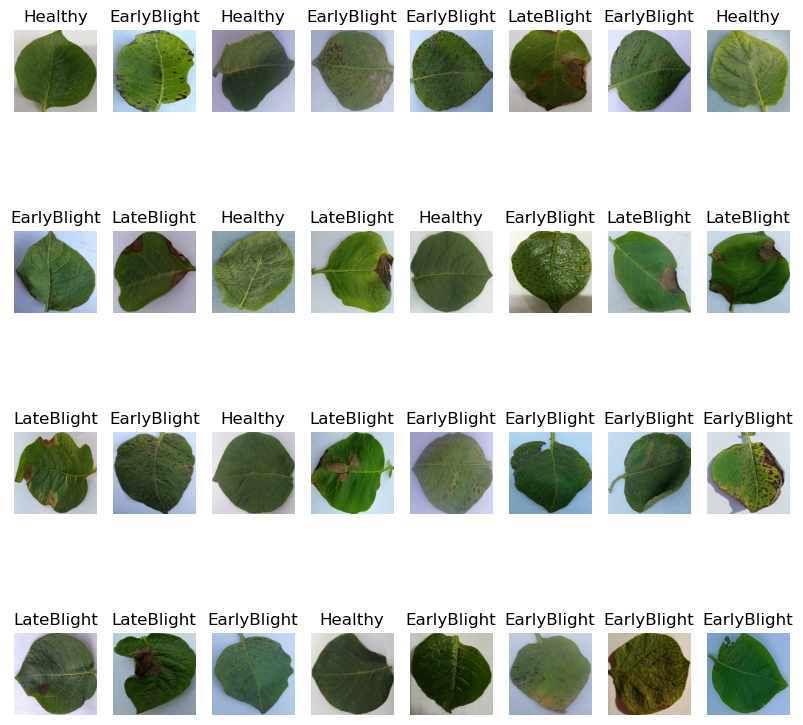

In [68]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(32):
        ax = plt.subplot(4, 8, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")
        
# generates a 4x8 grid of images from the first batch of the dataset, displaying them using matplotlib.
# Each subplot in the grid shows an image along with its corresponding class label. The figure size is set to 10x10 inches.

In [6]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds
#partitions a TensorFlow dataset (ds) into training, validation, and test sets based on specified split ratios.
#Shuffling is optionally performed, and the resulting sets (train_ds, val_ds, and test_ds) are returned, ensuring that the sum of split ratios equals 1. 

In [7]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)  
#obtaining three datasets: train_ds, val_ds, and test_ds

In [8]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
#caching elements for faster retrieval, shuffling them with a buffer size of 1000
#prefetching batches with a dynamic buffer size

In [9]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1.0/255),
])
#applies two sequential preprocessing layers to input images: resizing them to the specified IMAGE_SIZE and rescaling pixel values to a range between 0 and 1 using Resizing and Rescaling layers

In [10]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomZoom(height_factor=(-0.05, -0.15),width_factor=(-0.05, -0.15))
])
#defines a sequence of data augmentation layers, including random horizontal and vertical flips (RandomFlip), random rotations up to 20% (RandomRotation), and random zooming with height and width factors ranging from -5% to -15% (RandomZoom). 

In [11]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)
# applies data augmentation to the training dataset (train_ds) using the specified data_augmentation model
#prefetch method is then used to optimize data loading performance with a dynamic buffer size (tf.data.AUTOTUNE).

In [12]:
input_shape = ( BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE, CHANNELS)
n_classes = 3
#input_shape is defined with dimensions corresponding to the batch size, image height, image width, and number of channels, indicating the shape expected by the model.
#n_classes is set to 3, representing the number of classes in the classification task.

In [14]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_tensor=Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)))

pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                             final_sparsity=0.80,
                                                             begin_step=0,
                                                             end_step=int(len(train_ds) * 5),
                                                             frequency=100)
}

base_model = prune_low_magnitude(base_model, **pruning_params)

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Create a new model by adding a custom classification head on top of the base model
model = models.Sequential()
model.add(resize_and_rescale)
model.add(data_augmentation)
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))

In [22]:
model.build(input_shape=input_shape)

In [16]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [18]:
class WeightPruningCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Update the pruning step at the end of each epoch
        update_pruning_step = UpdatePruningStep()
        update_pruning_step.on_epoch_end(epoch, logs)

weight_pruning_callback = WeightPruningCallback()

In [20]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
    callbacks=[weight_pruning_callback]
)

Epoch 1/50
102/102 [==============================] - 356s 3s/step - loss: 0.4854 - accuracy: 0.8034 - val_loss: 1.1969 - val_accuracy: 0.5234
Epoch 2/50
102/102 [==============================] - 319s 3s/step - loss: 0.6290 - accuracy: 0.7410 - val_loss: 1.0224 - val_accuracy: 0.4505
Epoch 3/50
102/102 [==============================] - 1298s 13s/step - loss: 0.8247 - accuracy: 0.6275 - val_loss: 1.1283 - val_accuracy: 0.3516
Epoch 4/50
102/102 [==============================] - 550s 5s/step - loss: 0.9435 - accuracy: 0.5512 - val_loss: 1.0460 - val_accuracy: 0.4115
Epoch 5/50
102/102 [==============================] - 633s 6s/step - loss: 1.0216 - accuracy: 0.4728 - val_loss: 0.9980 - val_accuracy: 0.6198
Epoch 6/50
102/102 [==============================] - 342s 3s/step - loss: 0.9790 - accuracy: 0.5056 - val_loss: 0.9703 - val_accuracy: 0.5938
Epoch 7/50
102/102 [==============================] - 837s 8s/step - loss: 0.9211 - accuracy: 0.5552 - val_loss: 0.8900 - val_accuracy: 0.66

In [13]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_tensor=Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)))
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                             final_sparsity=0.90,
                                                             begin_step=0,
                                                             end_step=int(len(train_ds) * 5),
                                                             frequency=100)
}
base_model = prune_low_magnitude(base_model, **pruning_params)

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Create a new model by adding a custom classification head on top of the base model
model = models.Sequential()
model.add(resize_and_rescale)
model.add(data_augmentation)
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))

# One-hot encode the labels
def one_hot_encode_labels(labels):
    return tf.one_hot(labels, depth=3)

train_ds_encoded = train_ds.map(lambda x, y: (x, one_hot_encode_labels(y)))
val_ds_encoded = val_ds.map(lambda x, y: (x, one_hot_encode_labels(y)))
test_ds_encoded = test_ds.map(lambda x, y: (x, one_hot_encode_labels(y)))


# Compile the model with the pruning optimizer and the UpdatePruningStep callback
pruning_callbacks = [UpdatePruningStep()]
pruned_model = tfmot.sparsity.keras.strip_pruning(model)
pruned_model.compile(optimizer=Adam(),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])


#This code implements a pruned DenseNet121-based neural network for image classification.
#It begins by loading the pre-trained DenseNet121 model with weights from 'imagenet' and applies magnitude-based weight pruning to the model's weights, reducing the model size. The layers of the pre-trained model are frozen to retain the learned representations.
# A new classification model is then constructed by adding preprocessing layers (resizing and rescaling), data augmentation layers, the pruned base model, global average pooling, a dense layer with ReLU activation, dropout, and a final dense output layer with softmax activation. 
#The model is compiled with a pruning-aware optimizer (Adam) and categorical crossentropy as the loss function. 
#One-hot encoding is applied to the categorical labels in the training, validation, and test datasets. Finally, the model is stripped of pruning-related information, and training is initiated with a callback to update pruning during training.


In [14]:
pruned_model.build(input_shape=input_shape)
#builds the pruned model (pruned_model) with the specified input shape (input_shape), preparing it for training

In [16]:
pruned_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 densenet121 (Functional)    (None, 8, 8, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (32, 1024)               0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (32, 256)                 262400    
                                                                 
 dropout (Dropout)           (32, 256)                 0         
                                                      

In [17]:
# Calculate the total size of the model in megabytes
total_size_bytes = sum(tf.debugging.check_numerics(p, message='').shape.num_elements() * p.dtype.size for p in pruned_model.trainable_variables)
total_size_megabytes = total_size_bytes / (1024**2)  # Convert bytes to megabytes

print(f"Total size of the model: {total_size_megabytes:.2f} MB")

Total size of the model: 1.00 MB


In [92]:
# Check if the model is compiled and print its summary
if pruned_model:
    pruned_model.summary()
    # Train the model with the pruning callback
    history = pruned_model.fit(train_ds_encoded,
                               batch_size=BATCH_SIZE,
                               validation_data=val_ds_encoded,
                               epochs=EPOCHS,
                               callbacks=pruning_callbacks)
    
    # Evaluate the model on the test dataset
    test_loss, test_accuracy = pruned_model.evaluate(test_ds_encoded)
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
else:
    print("Error: Pruned model is not valid.")
    
    
#checks if the pruned model (pruned_model) exists. 
#If it does, the summary of the pruned model is printed, and the model is trained using the training dataset (train_ds_encoded) with specified batch size, validation data, and epochs.
# If the pruned model does not exist, an error message is displayed, indicating that the pruned model is not valid.

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 densenet121 (Functional)    (None, 8, 8, 1024)        7037504   
                                                                 
 global_average_pooling2d_5   (32, 1024)               0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_10 (Dense)            (32, 256)                 262400    
                                                                 
 dropout_5 (Dropout)         (32, 256)                 0         
                                                      

In [94]:
scores=pruned_model.evaluate(test_ds_encoded)
#Evaluates the pruned model on the test dataset and assigns the resulting scores, which typically include the test loss and accuracy, to the variable scores.

14/14 [==============================] - 21s 1s/step - loss: 0.1381 - accuracy: 0.9554


In [95]:
scores
#displays the test loss and accuracy

[0.13806791603565216, 0.9553571343421936]

In [96]:
history.params
#dictionary of parameters used to train the model

{'verbose': 1, 'epochs': 50, 'steps': 102}

In [97]:
history.history.keys()
# returns a list of the available metrics recorded during the training of a Keras model. 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [98]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
#extracts the training and validation accuracy as well as the training and validation loss from the training history (history).

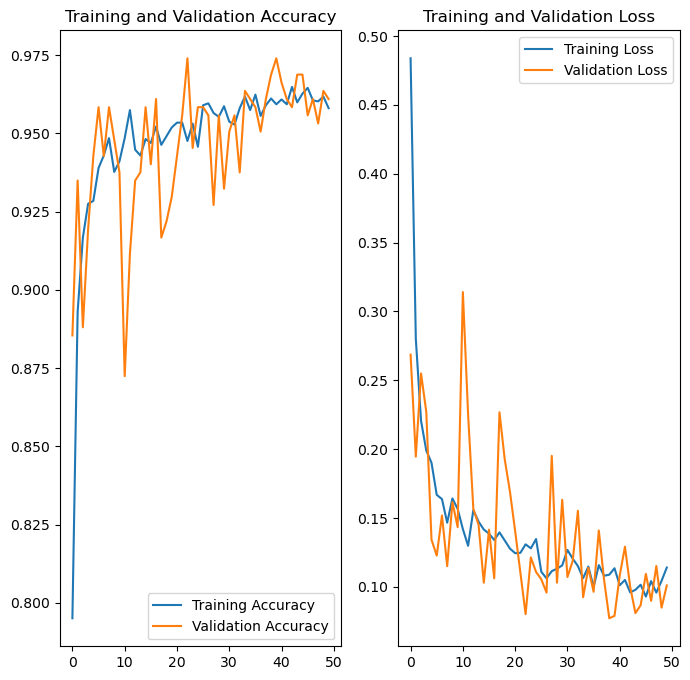

In [99]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
#This code uses matplotlib to create a 2x1 subplot figure with two side-by-side plots.
#The first subplot displays the training and validation accuracy over epochs, and the second subplot shows the training and validation loss.

first image to predict
actual label: EarlyBlight
1/1 [==============================] - 20s 20s/step
predicted label: EarlyBlight


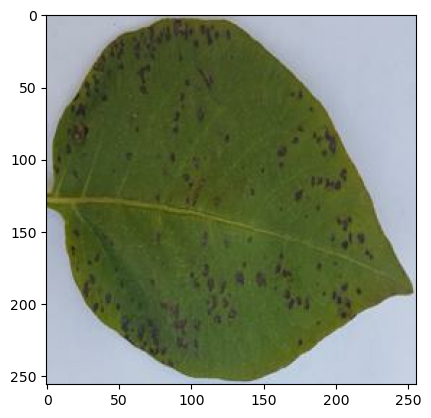

In [100]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])
    # selects the first image and its corresponding label from the test dataset, displaying the image and printing the actual label.
    #It then uses the trained modelto predict the label for the first image in the batch and prints the predicted label, showcasing a visual and comparative assessment of the model's performance on a sample test image.

first image to predict
actual label: Healthy
1/1 [==============================] - 1s 1s/step
predicted label: Healthy


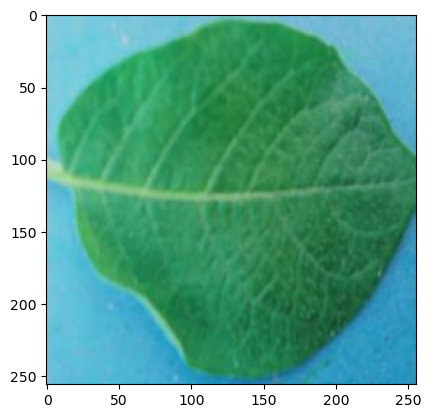

In [115]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[12].numpy().astype('uint8')
    first_label = labels_batch[12].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

first image to predict
actual label: EarlyBlight
1/1 [==============================] - 1s 1s/step
predicted label: EarlyBlight


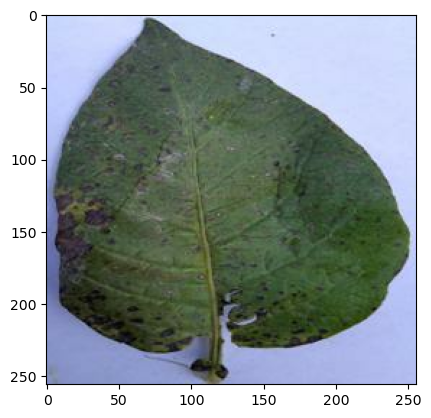

In [110]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[12].numpy().astype('uint8')
    first_label = labels_batch[12].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [3]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Make predictions on the test set
densenet_test_predictions = pruned_model.predict(test_ds)

# Convert one-hot encoded labels back to integers
densenet_test_labels = np.concatenate([y for _, y in test_ds])

# Convert the predicted probabilities to class labels
densenet_predicted_labels = np.argmax(densenet_test_predictions, axis=1)

# Calculate precision, recall, and F1 score
densenet_precision = precision_score(densenet_test_labels,densenet_predicted_labels, average='weighted')
densenet_recall = recall_score(densenet_test_labels,densenet_predicted_labels, average='weighted')
densenet_f1 = f1_score(densenet_test_labels,densenet_predicted_labels, average='weighted')
print(f'prruned_precision: {densenet_precision:.4f}')
print(f'pruned_recall: {densenet_recall:.4f}')

Precision is of the pruned model: 0.89
Recall is of the pruned model: 0.87
